## Objective:
- Fit a One vs All Random Forest Classifier for variable star data set imported from Xiaodian's website. 
- Show two examples variable star classes: one of with good accuracy outcome and one with moderate accuracy outcome

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Complete features and lables table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few example so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/
Feature list
- mean : mean of the light curve
- wmean : weight mean of the light curve
- MAD : deviation about the median
- IQR : inter quartile percentile of the light curve
- f60 : 60 percentile  of light curve
- f70 : 70 percentile of the light curve
- f80 : 80 percentile of the light curve
- f90 : 90 percentile of the light curve
- skew : skewness of the light curve
- kurtosis : kurtosis of the light curve
- welsk_k, welsh_j : welsh and staton J and K statistics of the light curve
- g_ : g band filter
- r_ : r band filter

In [3]:
df = pd.read_csv('features10000.csv', header=None, skiprows=1)
header = pd.read_csv('features10000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


## Drop rows with Blank values

In [5]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [7]:
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


## Plot histogram of variable types in the dataset

<AxesSubplot:xlabel='Type', ylabel='Count'>

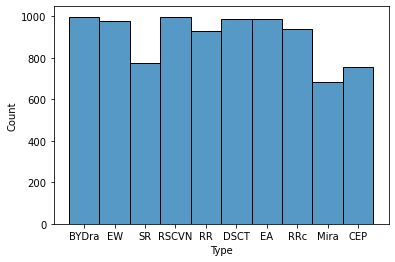

In [8]:
import seaborn as sns
sns.histplot(data=df, x=df.Type)

# Classify RR variable vs all

In [9]:
OneClass = 'RR'
df0 = df.copy()
df0.loc[df0.Type != OneClass,'Type'] = 'Other'
df1 = df0[df0.Type == 'Other']
df2 = df0[df0.Type == OneClass]

df3 = df1[0:1000] # balance data type by only selecting 1000 of other type
frames = [df2,df3]
df_onevsall = pd.concat(frames)

## Split into training and test data

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Map string labels to numbers
label = df_onevsall.Type


le = preprocessing.LabelEncoder()
le.fit(label)

# Drop columns that are not features
X = df0
# Encode labels to form y labels
y = le.transform(df0.Type)

# Split dataset into training set and test set
X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')

## Train a simple Random Forest

In [13]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Create a Gaussian Classifier
clf_RR=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_RR.fit(X_train,y_train)

# Predict test data output
y_pred = clf_RR.predict(X_test)
y_pred_train = clf_RR.predict(X_test)

# Estimate model accuracy on test data
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("Confusion matrix : ")
print(confusion_matrix(y_test, clf_RR.predict(X_test)))

Accuracy: 0.957533234859675
Confusion matrix : 
[[2408   40]
 [  75  185]]


## Visualize Feature importance

In [14]:
# feature importance
feature_imp = pd.Series(clf_RR.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

0
g_skew        0.152237
r_skew        0.089169
g_f90         0.056301
g_welsh_J     0.052605
r_welsh_K     0.049626
r_f90         0.044200
r_welsh_J     0.043310
g_f80         0.043213
r_f80         0.039704
g_f70         0.038196
g_f60         0.038136
r_mean        0.038032
r_f60         0.036894
r_f70         0.033980
g_mean        0.032882
g_wmean       0.031985
g_IQR         0.026833
g_MAD         0.024681
r_MAD         0.023702
g_kurtosis    0.023110
r_IQR         0.022516
r_wmean       0.022306
r_kurtosis    0.019014
g_welsh_K     0.017369
dtype: float64

No handles with labels found to put in legend.


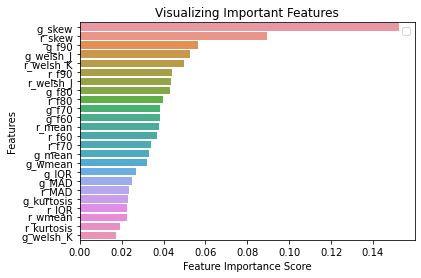

In [15]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Classify RSCVN variable vs all

In [17]:
OneClass = 'RSCVN'
df0 = df.copy()
df0.loc[df0.Type != OneClass,'Type'] = 'Other'
df1 = df0[df0.Type == 'Other']
df2 = df0[df0.Type == OneClass]

df3 = df1[0:1000] # balance data type by only selecting 1000 of other type
frames = [df2,df3]
df_onevsall = pd.concat(frames)

## Split into training and test data

In [19]:

# Map string labels to numbers
label = df_onevsall.Type


le = preprocessing.LabelEncoder()
le.fit(label)

# Drop columns that are not features
X = df0
# Encode labels to form y labels
y = le.transform(df0.Type)

# Split dataset into training set and test set
X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')

## Train a simple Random Forest

In [20]:
#Create a Gaussian Classifier
clf_RSCVN=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_RSCVN.fit(X_train,y_train)

# Predict test data output
y_pred=clf_RSCVN.predict(X_test)
y_pred_train = clf_RSCVN.predict(X_train)

# Estimate model accuracy on test data
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("Confusion matrix : ")
print(confusion_matrix(y_test, clf_RR.predict(X_test)))

Accuracy: 0.9132200886262924
Confusion matrix : 
[[2148  288]
 [ 271    1]]


## Prediction Error distribution accross variable type class

<AxesSubplot:xlabel='Test', ylabel='Count'>

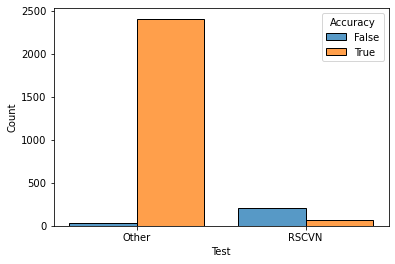

In [21]:
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Form a dataframe of test vs predicted labels
pd_prediction = pd.DataFrame()
pd_prediction['Test'] = y_test_labels
pd_prediction['Pred'] = y_pred_labels
pd_prediction['Accuracy'] = y_test_labels == y_pred_labels
pd_prediction.head()

sns.histplot(data=pd_prediction, x=pd_prediction.Test, hue = pd_prediction.Accuracy,multiple="dodge", shrink=.8)


## Visualize Feature importance

In [22]:
# feature importance
feature_imp = pd.Series(clf_RSCVN.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

0
r_f90         0.063006
g_f90         0.062474
r_f80         0.058302
r_f70         0.048466
g_welsh_J     0.048257
r_welsh_K     0.046332
g_f70         0.044500
r_f60         0.043460
r_skew        0.043224
g_f80         0.041309
r_mean        0.041057
g_mean        0.039197
g_f60         0.038513
g_kurtosis    0.038405
g_skew        0.038005
g_wmean       0.037753
r_kurtosis    0.037430
r_wmean       0.035442
g_welsh_K     0.034613
g_IQR         0.034443
r_IQR         0.033053
r_welsh_J     0.031728
r_MAD         0.030696
g_MAD         0.030334
dtype: float64

No handles with labels found to put in legend.


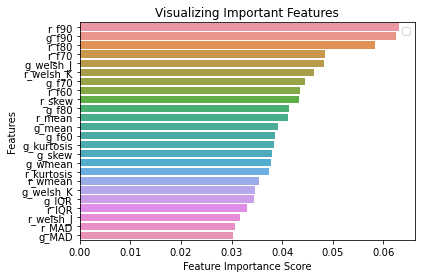

In [23]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()